In [42]:
import scipy.signal, scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline

In [43]:
def plotDataSection(data, title, startTime=0, endTime=None, sampleRate=24e3):
    if endTime is None:
        endTime = len(data)/sampleRate
        sectionLength = len(data)
        data_section = data        
    else:
        idxStart = int(startTime*sampleRate)
        idxEnd = int(endTime*sampleRate)
        sectionLength = idxEnd - idxStart
        data_section = data[idxStart: idxEnd]
    time = np.linspace(startTime, endTime, num=sectionLength)
    fig, ax = plt.subplots()
    ax.plot(time, data_section)
    ax.set_title(title)
    ax.set_xlim([startTime, endTime])
    ax.set_xlabel('time [s]')
    ax.set_ylabel('voltage [uv]')
    ax.grid(True)
    return fig, ax

def plotSectionMeanAndSTD(data, title, sampleRate=24e3):
    dataMean = data.mean(axis=0)
    time = np.linspace(0, len(dataMean)/sampleRate, num=len(dataMean))
    dataSTD = data.std(axis=0)
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(211)
    ax1.plot(time, dataMean, color='b')
    ax1.plot(time, dataMean + dataSTD, 'r.')
    ax1.plot(time, dataMean - dataSTD, 'r.')
    ax1.set_title(title)
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('voltage [uv]')
    ax1.grid(True)
    ax2 = fig.add_subplot(212)
    ax2.plot(time, dataSTD)
    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('STD')
    ax2.grid(True)

def getPeakSections(data, idxPeaks, windowSizeBefore, windowSizeAfter):
    peakSections = []
    for i in idxPeaks:
        peakSections.append(data[i - windowSizeBefore: i + windowSizeAfter])
    return np.array(peakSections)

def removeOutOfBoundIdx(idx, lowBound, upBound):
    '''Remove the idx that are too close to the begining or end 
    defined by lowBound and upBound.
    Needed to avoid index out of bound error when cutting data into small sections.
    '''
    return idx[np.logical_and(idx > lowBound, idx < upBound)]

In [44]:
sampleRate = 32051
dataFile = 'recording.npy'

In [45]:
origData = np.load(dataFile)
recLength = len(origData) / sampleRate
print(f'recording length {recLength:8.2f} seconds.')

recording length  1903.22 seconds.


In [46]:
freq, OrigPSD = scipy.signal.welch(origData, sampleRate, window=scipy.signal.windows.hann(2**16))

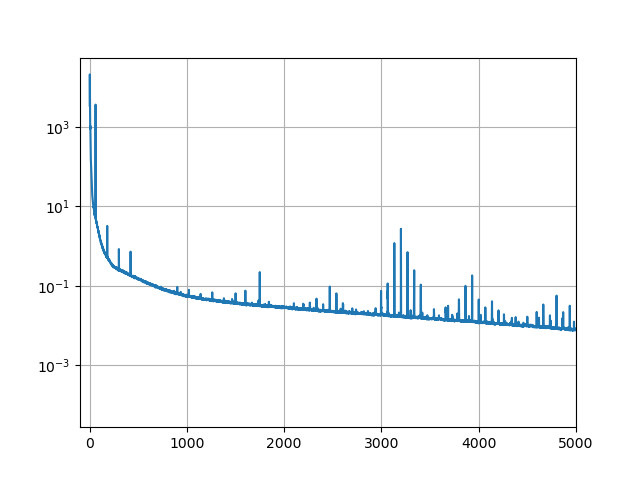

In [47]:
fig, ax = plt.subplots()
ax.plot(freq, OrigPSD)
ax.set_xlim([-100, 5000])
ax.set_yscale('log')
ax.grid(True)

Filtering

In [48]:
sos = scipy.signal.iirfilter(8, [300,2000], btype='bandpass',ftype='butter', output='sos',fs=sampleRate)
filteredData = scipy.signal.sosfilt(sos, origData)

In [49]:
freq, filteredPSD = scipy.signal.welch(filteredData, sampleRate, window=scipy.signal.windows.hann(2**16))

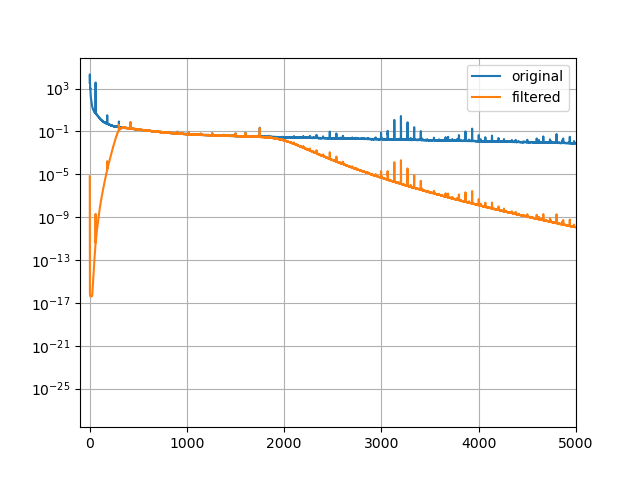

In [50]:
fig, ax = plt.subplots()
ax.plot(freq, OrigPSD, label='original')
ax.plot(freq, filteredPSD, label='filtered')
ax.set_xlim([-100, 5000])
ax.set_yscale('log')
ax.grid(True)
ax.legend()

Finding peaks

In [61]:
distanceThreshold = 300
windowSizeBefore = 100
windowSizeAfter = 200

# peak amplitude threshold
sigma = np.median((np.absolute(filteredData))/0.6745)
heightThreshold = 4*sigma
print(f'amplitude threshold: {heightThreshold}')

# finding peaks
idxPeaks, peakProperties = scipy.signal.find_peaks(
    filteredData, height=heightThreshold, distance=distanceThreshold)
idxPeaks = idxPeaks[idxPeaks > windowSizeBefore]
print(f'number of peaks found: {len(idxPeaks)}')

peakSections = getPeakSections(filteredData, idxPeaks, windowSizeBefore, windowSizeAfter)

amplitude threshold: 40.61747674680403
number of peaks found: 7108


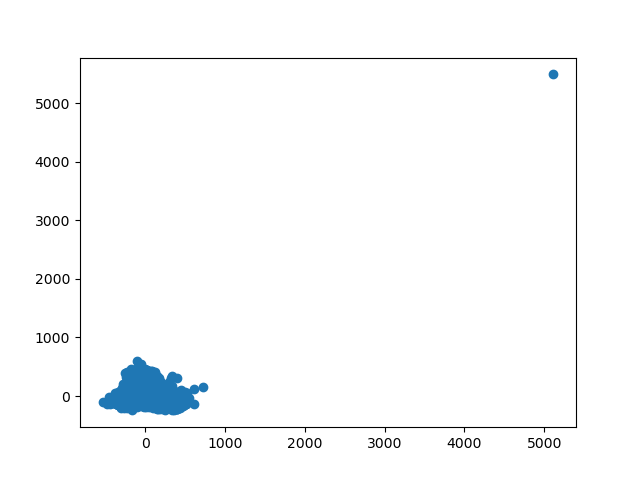

In [62]:
numPC = 10

pca = PCA(n_components=numPC)
pca.fit(peakSections)
peakPC = pca.transform(peakSections)

fig, ax = plt.subplots()
ax.scatter(peakPC[:, 0],peakPC[:, 1])

Remove outliers

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'outlier waveform'}, xlabel='time [s]', ylabel='voltage [uv]'>)

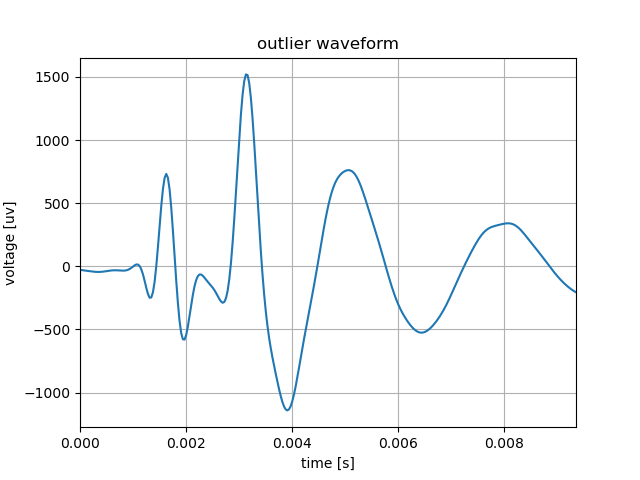

In [63]:
mask = np.logical_and(
    np.abs(peakPC[:, 0]) < 2000,
    np.abs(peakPC[:, 1]) < 2000,
    )
peakSectionsNoOutlier = peakSections[mask]
idxPeaksNoOutlier = idxPeaks[mask]

outlier = peakSections[np.logical_not(mask)]

plotDataSection(outlier.squeeze(), 'outlier waveform', sampleRate=sampleRate)

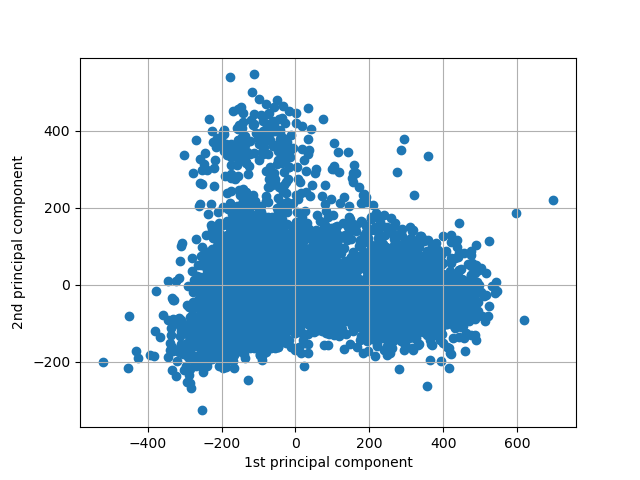

In [64]:
pca.fit(peakSectionsNoOutlier)
peakPCNoOutlier = pca.transform(peakSectionsNoOutlier)

fig, ax = plt.subplots()
ax.scatter(peakPCNoOutlier[:, 0], peakPCNoOutlier[:, 1])
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')
ax.grid(True)

In [65]:
plt.plot(pca.explained_variance_)

In [66]:
numClusters = 2

kMeanCluster = KMeans(n_clusters=numClusters, n_init=10)
kMeanCluster.fit(peakPCNoOutlier)
# for i in range(numClusters):
#     plotDataSection(
#         pca.inverse_transform(kMeanCluster.cluster_centers_[i]), f'spike type {i}')

KMeans(n_clusters=2)

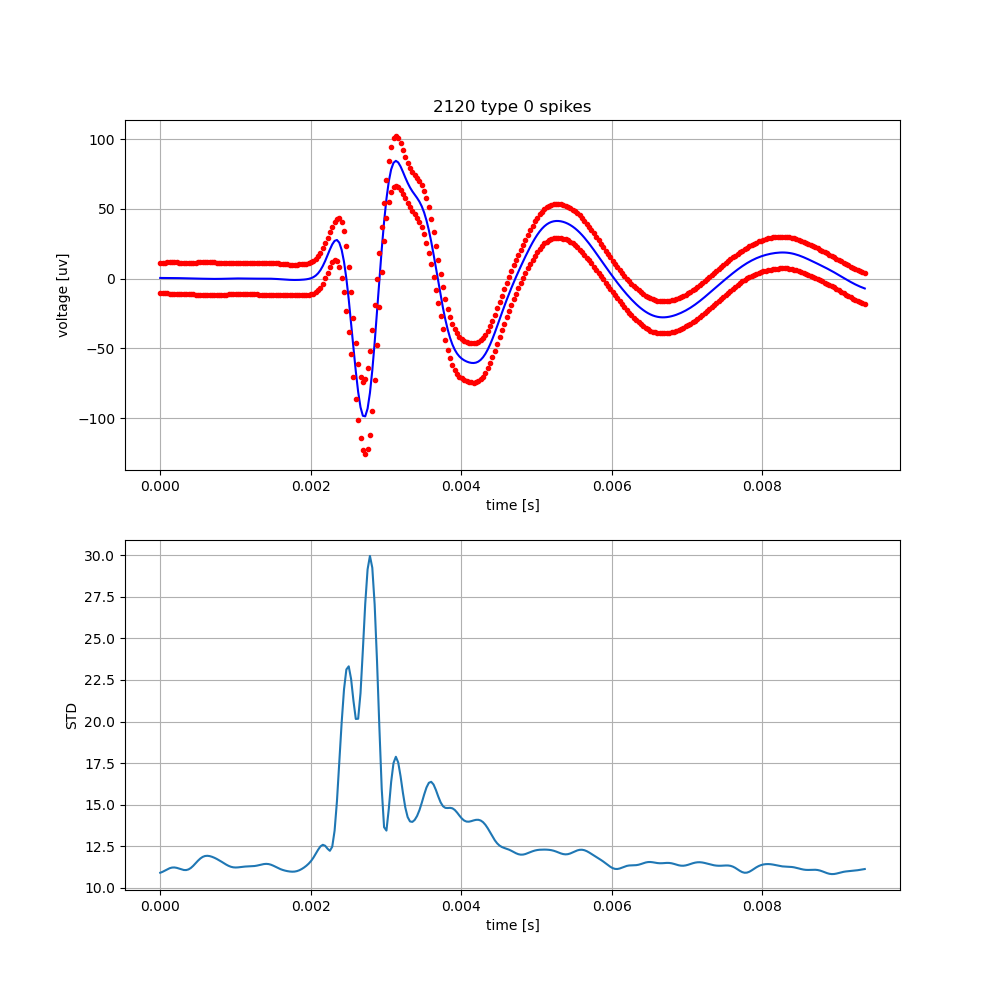

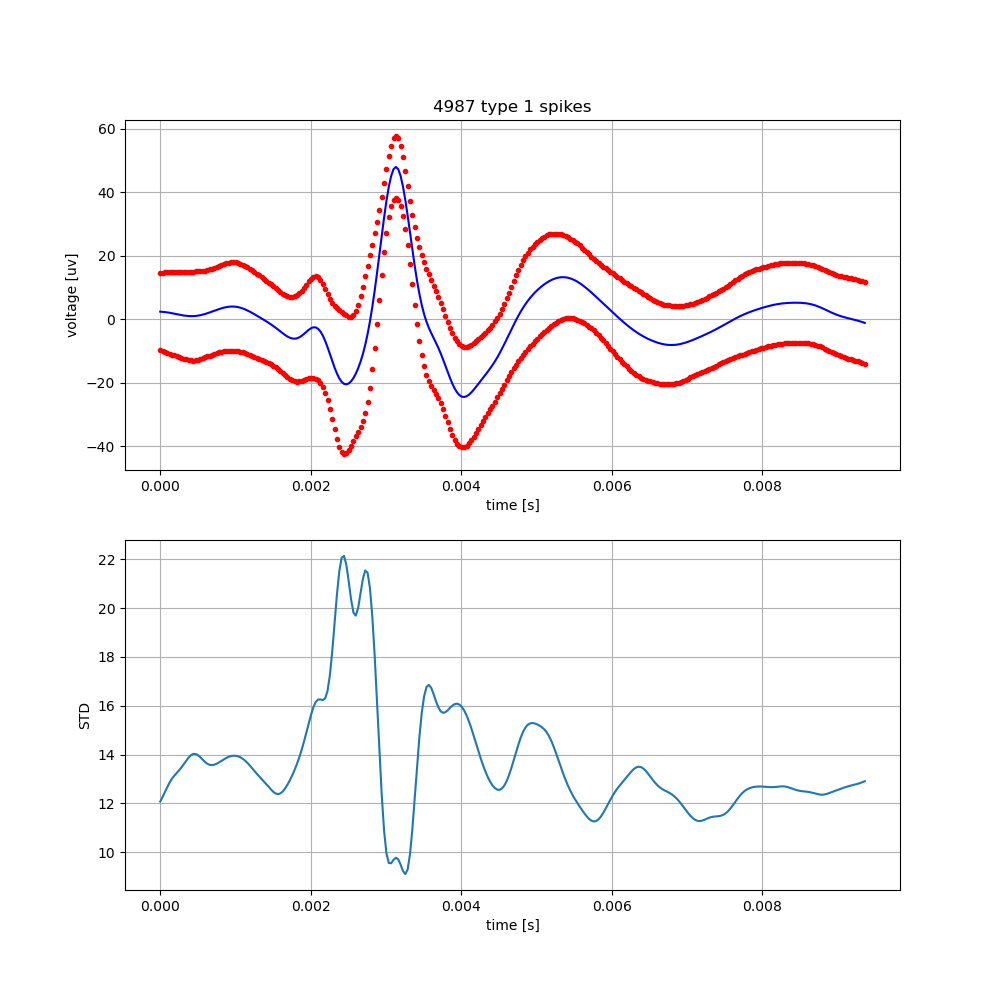

In [67]:
for idxCluster in range(numClusters):
    clusterSections = peakSectionsNoOutlier[kMeanCluster.labels_ == idxCluster]
    title = f'{sum(kMeanCluster.labels_ == idxCluster)} type {idxCluster} spikes'
    plotSectionMeanAndSTD(clusterSections, title, sampleRate)

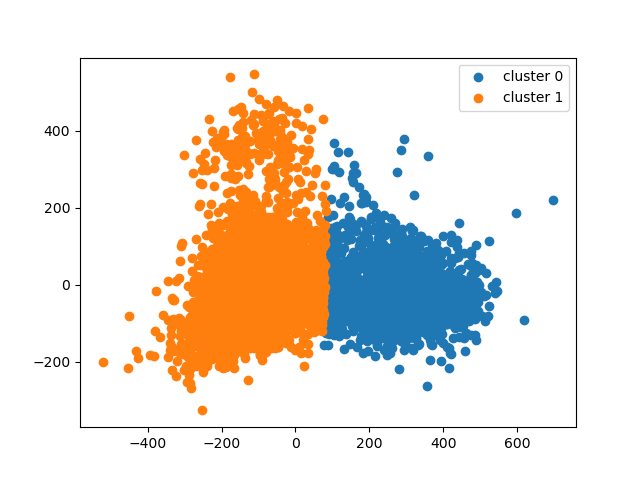

In [68]:
fig, ax = plt.subplots()
for idxCluster in range(numClusters):
    clusterPC = peakPCNoOutlier[kMeanCluster.labels_ == idxCluster]
    ax.scatter(clusterPC[:, 0], clusterPC[:, 1], label=f'cluster {idxCluster}')
ax.legend()

Mark the peaks on filtered data

In [69]:
idxPeaks_Cluster = []
for idxCluster in range(numClusters):
    idxPeaks_Cluster.append(idxPeaksNoOutlier[kMeanCluster.labels_ == idxCluster])

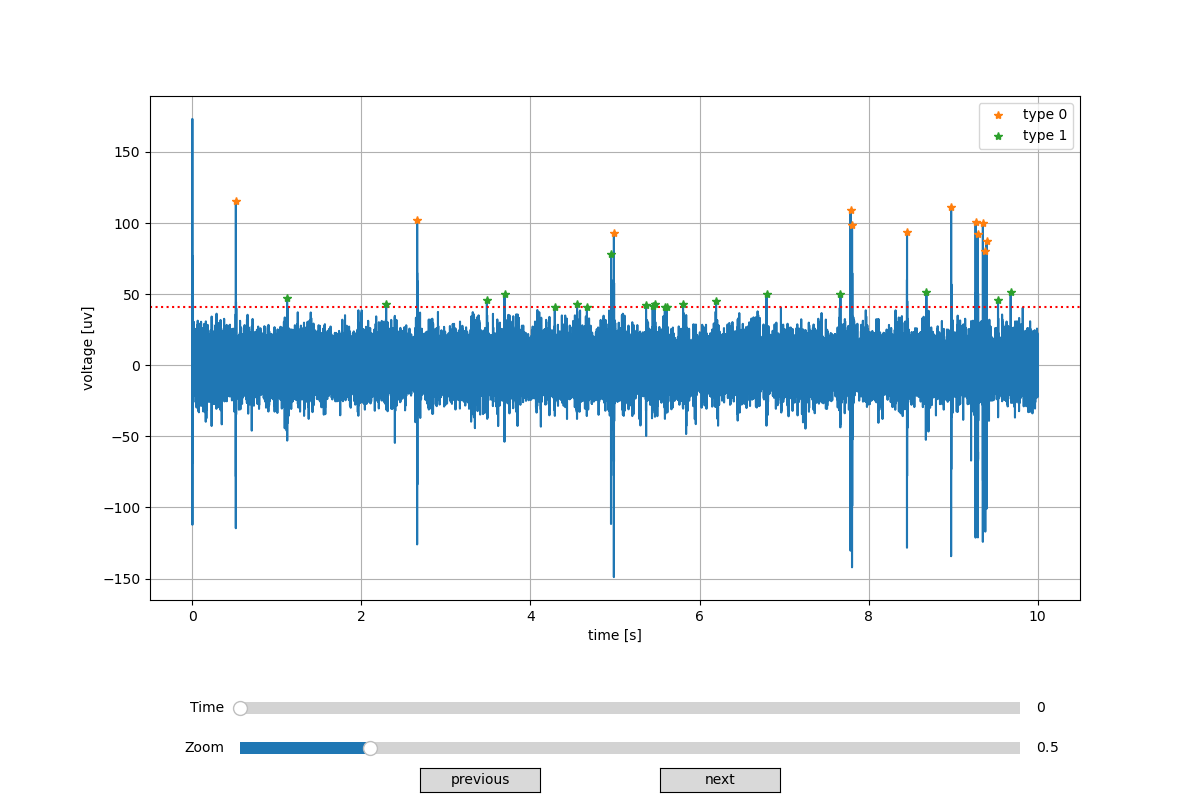

In [70]:
%matplotlib widget
from matplotlib.widgets import Slider, Button

origWindowSize = 10
plotWindowSize = 10 # [seconds]

time = np.linspace(0, len(filteredData)/sampleRate, num=len(filteredData))
startIdx = 0
endIdx = int(plotWindowSize*sampleRate)
startTime = 0

fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(bottom=0.25)
curve = ax.plot(time[startIdx: endIdx], filteredData[startIdx: endIdx])
ax.axhline(y=heightThreshold, color ='r', linestyle =':')

allMarkers = []
for idxCluster in range(numClusters):
    idx = idxPeaks_Cluster[idxCluster]
    mask = np.logical_and(idx >= startIdx, idx < endIdx)
    idx = idx[mask]
    marker = ax.plot(time[idx], filteredData[idx], '*', label=f'type {idxCluster}')
    allMarkers.append(marker)

ax.grid(True)
ax.set_xlabel('time [s]')
ax.set_ylabel('voltage [uv]')

ax.legend()

timeSlider = Slider(
    (plt.axes([0.2, 0.1, 0.65, 0.03], facecolor = 'White')),
    label='Time', 
    valmin = 0.0, 
    valmax = recLength
)

zoomSlider = Slider(
    (plt.axes([0.2, 0.05, 0.65, 0.03], facecolor = 'White')),
    label='Zoom', 
    valmin = 0.0, 
    valmax = 3
)

prevButton = Button((plt.axes([0.35, 0.01, 0.1, 0.03])), label='previous')
nextButtom = Button((plt.axes([0.55, 0.01, 0.1, 0.03])), label='next')


def update(startTime):
    global startIdx, endIdx
    startIdx = int(startTime*sampleRate)
    endIdx = int((startTime + plotWindowSize)*sampleRate)
    curve[0].set_xdata(time[startIdx: endIdx])
    newData = filteredData[startIdx: endIdx]
    curve[0].set_ydata(newData)
    ax.set_xlim([startTime, startTime + plotWindowSize])
    ax.set_ylim([newData.min()*1.2, newData.max()*1.2])
    for idxCluster in range(numClusters):
        idx = idxPeaks_Cluster[idxCluster]
        mask = np.logical_and(idx >= startIdx, idx < endIdx)
        idx = idx[mask]
        marker = allMarkers[idxCluster][0]
        marker.set_xdata(time[idx])
        marker.set_ydata(filteredData[idx])    
    fig.canvas.draw_idle()

def changeTime(val):
    global startTime
    startTime = timeSlider.val
    update(startTime)

def zoom(val):
    global plotWindowSize, startTime
    oldCenterTime = startTime + plotWindowSize/2
    plotWindowSize = origWindowSize/(10**zoomSlider.val)
    startTime = oldCenterTime - plotWindowSize/2
    # zoomSlider.set_val(startTime)
    update(startTime)

def getCurrentPeakIdx(startTime):
    currentCenterTime = startTime + plotWindowSize/2
    currentCenterIdx = int(currentCenterTime*sampleRate)
    nearestPeakIdx = idxPeaksNoOutlier[np.abs(idxPeaksNoOutlier - currentCenterIdx).argmin()]
    return nearestPeakIdx

def nextPeak(val):
    global startTime
    nextPeakIdx = idxPeaksNoOutlier[idxPeaksNoOutlier > endIdx].min()
    startTime = time[nextPeakIdx] - plotWindowSize/2
    timeSlider.set_val(startTime)
    update(startTime)

def prevPeak(val):
    global startTime
    prevPeakIdx = idxPeaksNoOutlier[idxPeaksNoOutlier < startIdx].max()
    startTime = time[prevPeakIdx] - plotWindowSize/2
    timeSlider.set_val(startTime)
    update(startTime)

timeSlider.on_changed(update)
zoomSlider.on_changed(zoom)
nextButtom.on_clicked(nextPeak)
prevButton.on_clicked(prevPeak)

plt.show()

In [71]:
a = np.array([0,1,2,3])
a[a > 1].min()

2

In [72]:
plt.close()
%matplotlib inline

Elbow method for the number of clusters

In [73]:
n = []
inertia = []
for numClusters in range(2, 20):
    kMeanCluster = KMeans(n_clusters=numClusters, n_init=10)
    kMeanCluster.fit(peakPC)
    n.append(numClusters)
    inertia.append(kMeanCluster.inertia_)

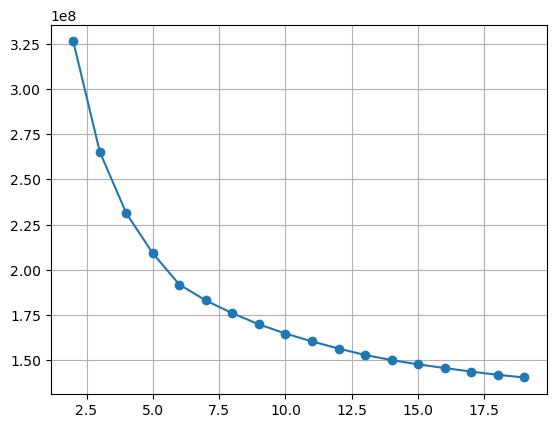

In [74]:
fig, ax = plt.subplots()
ax.plot(n, inertia, 'o-')
ax.grid(True)